In [1]:
import numpy as np
from scipy.integrate import odeint
from matplotlib import pyplot as plt

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam

In [2]:
class DNN:
    def __init__(self, input_size, output_size, dropout=0.4, model=None):
        if model == None:
            self.model = self.generate_model(input_size, output_size, dropout)
        else:
            self.model = model
    
    def generate_model(self,input_size,output_size,dropout):
        optimizer = Adam()
        input_layer = Input(shape=(input_size,), name="Input") 
        dense_layer = Dense(150, activation='relu')(input_layer)
        #dense_layer = Dropout(dropout)(dense_layer)
        dense_layer = Dense(150, activation='relu')(dense_layer)
        #dense_layer = Dropout(dropout)(dense_layer)
        dense_layer = Dense(150, activation='relu')(dense_layer)
        #dense_layer = Dropout(dropout)(dense_layer)
        dense_layer = Dense(150, activation='relu')(dense_layer)
        #dense_layer = Dropout(dropout)(dense_layer)
        dense_layer = Dense(100, activation='relu')(dense_layer)
        #dense_layer = Dropout(dropout)(dense_layer)
        output_layer = Dense(output_size, activation='tanh', name="Output")(dense_layer)
        model = Model(input_layer, output_layer)
        model.compile(loss="mean_squared_error", optimizer=optimizer, metrics=['accuracy'])
        return model
    
    def train(self, data, labels, epochs = 150, batch_size = 32, save = True):
        self.model.fit(data, labels, epochs = epochs, batch_size = batch_size, verbose = 1)
        if save: 
            self.model.save("ThreeBodyDNN.h5")
        
    def predict(self, system):
        return self.model.predict(system)
    
    def get_path(self, system, steps):
        mass = system[:3] 
        path = [system[3:] * SCALE] 
        prev = system[3:] * SCALE

        for _ in range(steps):
            combined = np.concatenate((mass, prev)).reshape(-1,15)
            next_path = self.predict(combined)
            path.append(next_path[0])
            prev = next_path[0]
            
        return np.array(path) / SCALE

In [3]:
def ThreeBody(y, t, M):
    equations = np.empty((12, ))
    
    # Radii
    R12 = np.sqrt((y[0]-y[4])**2+(y[1]-y[5])**2)
    R13 = np.sqrt((y[0]-y[8])**2+(y[1]-y[9])**2)
    R23 = np.sqrt((y[4]-y[8])**2+(y[5]-y[9])**2)
    
    # Body 0
    equations[0] = y[2]
    equations[1] = y[3]
    equations[2] = G*M[1]*(y[4]-y[0])/(R12**3)+G*M[2]*(y[8]-y[0])/(R13**3)
    equations[3] = G*M[1]*(y[5]-y[1])/(R12**3)+G*M[2]*(y[9]-y[1])/(R13**3)
    
    # Body 1
    equations[4] = y[6]
    equations[5] = y[7]
    equations[6] = G*M[0]*(y[0]-y[4])/(R12**3)+G*M[2]*(y[8]-y[4])/(R23**3)
    equations[7] = G*M[0]*(y[1]-y[5])/(R12**3)+G*M[2]*(y[9]-y[5])/(R23**3)
    
    # Body 2
    equations[8] = y[10]
    equations[9] = y[11]
    equations[10] = G*M[0]*(y[0]-y[8])/(R13**3)+G*M[1]*(y[4]-y[8])/(R23**3)
    equations[11] = G*M[0]*(y[1]-y[9])/(R13**3)+G*M[1]*(y[5]-y[9])/(R23**3)
    
    return equations

In [10]:
def get_sample(time):
    M = np.random.rand(3)
    Y0 = np.random.rand(12) * 2 - np.ones(12)
    T = np.arange(0, time+DT, DT)
    RK = odeint(ThreeBody, Y0, T, (M, ))
    return np.concatenate((M, Y0 * SCALE)).tolist(), (RK * SCALE)

In [5]:
def get_training_data(sample):
    IV = []
    solution = []
    for _ in range(sample):
        i, s = get_sample(DT)
        IV.append(i)
        solution.append(s[1])
    return np.array(IV), np.array(solution)

In [6]:
def get_actual_path(sample, duration):
    M = sample[:3]
    Y0 = sample[3:]
    T = np.arange(0, duration+DT, DT)
    
    RK = odeint(ThreeBody, Y0, T, (M, ))
    
    return RK

In [22]:
G = 0.6674
DT = 0.01
MAX_TIME = 1
SCALE = 0.1
NUM_OF_SAMPLES = 1000

In [23]:
train, label = get_training_data(NUM_OF_SAMPLES)

In [24]:
dnn = DNN(input_size = 15, output_size = 12, dropout=0.1)
dnn.train(data = train, labels = label, epochs=40)

Epoch 1/40
1000/1000 [==============================] - 1s 1ms/step - loss: 0.0046 - acc: 0.1470
Epoch 2/40
1000/1000 [==============================] - 0s 343us/step - loss: 0.0034 - acc: 0.3310
Epoch 3/40
1000/1000 [==============================] - 0s 349us/step - loss: 0.0025 - acc: 0.4320
Epoch 4/40
1000/1000 [==============================] - 0s 344us/step - loss: 0.0019 - acc: 0.5610
Epoch 5/40
1000/1000 [==============================] - 0s 338us/step - loss: 0.0018 - acc: 0.5890
Epoch 6/40
1000/1000 [==============================] - 0s 332us/step - loss: 0.0016 - acc: 0.6560
Epoch 7/40
1000/1000 [==============================] - 0s 338us/step - loss: 0.0016 - acc: 0.6790
Epoch 8/40
1000/1000 [==============================] - 0s 329us/step - loss: 0.0016 - acc: 0.6490
Epoch 9/40
1000/1000 [==============================] - 0s 331us/step - loss: 0.0015 - acc: 0.6510
Epoch 10/40
1000/1000 [==============================] - 0s 350us/step - loss: 0.0015 - acc: 0.6460
Epoch 11/40

In [35]:
sample = np.random.rand(15)
generated_path = dnn.get_path(sample, steps=int(MAX_TIME/DT))
actual_path = get_actual_path(sample, duration=MAX_TIME)

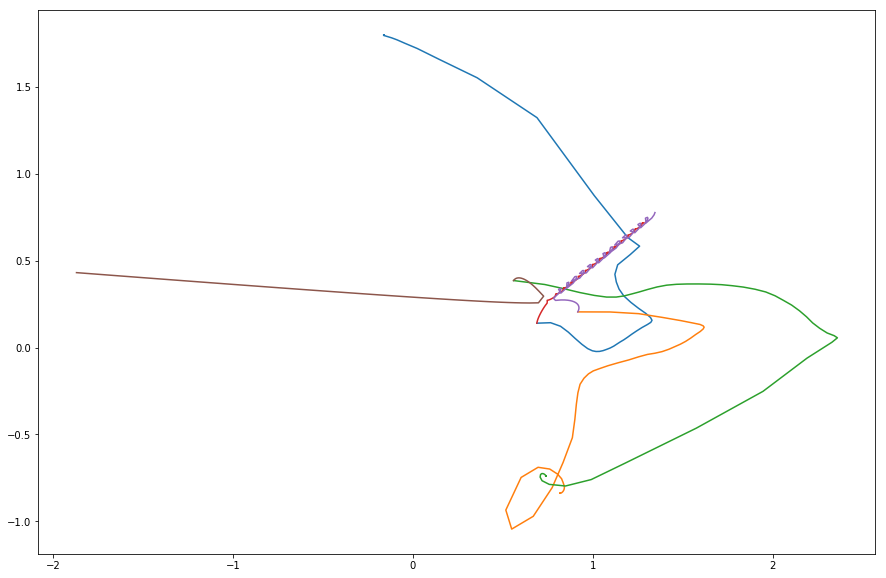

In [36]:
plt.figure(figsize=(15,10))

#plt.plot(generated_path[:,1])
#plt.plot(actual_path[:,1])
plt.plot(generated_path[:,0], generated_path[:,1])
plt.plot(generated_path[:,4], generated_path[:,5])
plt.plot(generated_path[:,8], generated_path[:,9])
plt.plot(actual_path[:,0], actual_path[:,1])
plt.plot(actual_path[:,4], actual_path[:,5])
plt.plot(actual_path[:,8], actual_path[:,9])

plt.show()